In [1]:
import sys
# !pip3 install matplotlib
# !pip3 install pandas
# !pip3 install seaborn
# !pip3 install --upgrade tensorflow-gpu
# !pip3 install import-ipynb
# !pip3 install cuda-python
# !pip3 install -U scikit-learn
# !pip3 install bayesian-optimization

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import math
import pickle
import time

import import_ipynb
import AttackClassificationModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from bayes_opt import BayesianOptimization

%matplotlib inline

importing Jupyter notebook from AttackClassificationModel.ipynb


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Data Pre-Processing

In [3]:
df_gafgyt = AttackClassificationModel.get_files_nbaiot_gafgyt_edsw('../../nbaiot/Ennio_Doorbell/gafgyt')

# Gafgyt Combo
df_gafgyt_combo, label_gafgyt_combo = AttackClassificationModel.get_attack(0, df_gafgyt)

# Gafgyt Junk
df_gafgyt_junk, label_gafgyt_junk = AttackClassificationModel.get_attack(1, df_gafgyt)

# Gafgyt Scan
df_gafgyt_scan, label_gafgyt_scan = AttackClassificationModel.get_attack(2, df_gafgyt)

# Gafgyt Tcp
df_gafgyt_tcp, label_gafgyt_tcp = AttackClassificationModel.get_attack(3, df_gafgyt)

# Gafgyt Udp
df_gafgyt_udp, label_gafgyt_udp = AttackClassificationModel.get_attack(4, df_gafgyt)

In [4]:
# Normalize with the min-max scaler
scaler = MinMaxScaler()
df_gafgyt_combo_norm = scaler.fit_transform(df_gafgyt_combo)
df_gafgyt_junk_norm = scaler.fit_transform(df_gafgyt_junk)
df_gafgyt_scan_norm = scaler.fit_transform(df_gafgyt_scan)
df_gafgyt_tcp_norm = scaler.fit_transform(df_gafgyt_tcp)
df_gafgyt_udp_norm = scaler.fit_transform(df_gafgyt_udp)

# Sets

In [5]:
# Train
len_gafgyt_combo_train = int(0.7 * len(df_gafgyt_combo_norm))
X_gafgyt_combo_train = df_gafgyt_combo_norm[:len_gafgyt_combo_train]

len_gafgyt_junk_train = int(0.7 * len(df_gafgyt_junk_norm))
X_gafgyt_junk_train = df_gafgyt_junk_norm[:len_gafgyt_junk_train]

len_gafgyt_scan_train = int(0.7 * len(df_gafgyt_scan_norm))
X_gafgyt_scan_train = df_gafgyt_scan_norm[:len_gafgyt_scan_train]

len_gafgyt_tcp_train = int(0.7 * len(df_gafgyt_tcp_norm))
X_gafgyt_tcp_train = df_gafgyt_tcp_norm[:len_gafgyt_tcp_train]

len_gafgyt_udp_train = int(0.7 * len(df_gafgyt_udp_norm))
X_gafgyt_udp_train = df_gafgyt_udp_norm[:len_gafgyt_udp_train]

X_train = np.concatenate([X_gafgyt_combo_train, X_gafgyt_junk_train, X_gafgyt_scan_train, X_gafgyt_tcp_train, X_gafgyt_udp_train])
Y_train = np.concatenate([label_gafgyt_combo[:len_gafgyt_combo_train], label_gafgyt_junk[:len_gafgyt_junk_train], 
                          label_gafgyt_scan[:len_gafgyt_scan_train], label_gafgyt_tcp[:len_gafgyt_tcp_train], label_gafgyt_udp[:len_gafgyt_udp_train]])

In [6]:
#Test
len_gafgyt_combo_test = len_gafgyt_combo_train + int(0.15 * len(df_gafgyt_combo_norm))
X_gafgyt_combo_test = df_gafgyt_combo_norm[len_gafgyt_combo_train : len_gafgyt_combo_test]

len_gafgyt_junk_test = len_gafgyt_junk_train + int(0.15 * len(df_gafgyt_junk_norm))
X_gafgyt_junk_test = df_gafgyt_junk_norm[len_gafgyt_junk_train : len_gafgyt_junk_test]

len_gafgyt_scan_test = len_gafgyt_scan_train + int(0.15 * len(df_gafgyt_scan_norm))
X_gafgyt_scan_test = df_gafgyt_scan_norm[len_gafgyt_scan_train : len_gafgyt_scan_test]

len_gafgyt_tcp_test = len_gafgyt_tcp_train + int(0.15 * len(df_gafgyt_tcp_norm))
X_gafgyt_tcp_test = df_gafgyt_tcp_norm[len_gafgyt_tcp_train : len_gafgyt_tcp_test]

len_gafgyt_udp_test = len_gafgyt_udp_train + int(0.15 * len(df_gafgyt_udp_norm))
X_gafgyt_udp_test = df_gafgyt_udp_norm[len_gafgyt_udp_train : len_gafgyt_udp_test]

X_test = np.concatenate([X_gafgyt_combo_test, X_gafgyt_junk_test, X_gafgyt_scan_test, X_gafgyt_tcp_test, X_gafgyt_udp_test])
Y_test = np.concatenate([label_gafgyt_combo[len_gafgyt_combo_train : len_gafgyt_combo_test], label_gafgyt_junk[len_gafgyt_junk_train : len_gafgyt_junk_test], 
                         label_gafgyt_scan[len_gafgyt_scan_train : len_gafgyt_scan_test], label_gafgyt_tcp[len_gafgyt_tcp_train : len_gafgyt_tcp_test], label_gafgyt_udp[len_gafgyt_udp_train : len_gafgyt_udp_test]])


In [7]:
# Validation
X_gafgyt_combo_val = df_gafgyt_combo_norm[len_gafgyt_combo_test:]
X_gafgyt_junk_val = df_gafgyt_junk_norm[len_gafgyt_junk_test:]
X_gafgyt_scan_val = df_gafgyt_scan_norm[len_gafgyt_scan_test:]
X_gafgyt_tcp_val = df_gafgyt_tcp_norm[len_gafgyt_tcp_test:]
X_gafgyt_udp_val = df_gafgyt_udp_norm[len_gafgyt_udp_test:]

X_val = np.concatenate([X_gafgyt_combo_val, X_gafgyt_junk_val, X_gafgyt_scan_val, X_gafgyt_tcp_val, X_gafgyt_udp_val])
Y_val = np.concatenate([label_gafgyt_combo[len_gafgyt_combo_test:], label_gafgyt_junk[len_gafgyt_junk_test:], 
                        label_gafgyt_scan[len_gafgyt_scan_test:], label_gafgyt_tcp[len_gafgyt_tcp_test:], label_gafgyt_udp[len_gafgyt_udp_test:]])

In [8]:
X_train_CNN = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_CNN = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val_CNN = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

samples, feature, depth = X_train_CNN.shape

# Model

In [9]:
# Initial values
batch_size = 32
learning_rate = 0.008
epochs = 5

# Dictionary
dict_params = { 'learning_rate': learning_rate, 'batch_size': round(batch_size), 'epochs': round(epochs) }
pbounds = { 'learning_rate': (0.000001, 0.001), 'batch_size': (10, 23), 'epochs': (1, 100) }

In [10]:
cnn_model = AttackClassificationModel.CNN(feature, depth, 5)
reduce_lr = ReduceLROnPlateau(moniter = 'val_loss', factor = 0.1, patience = 10)

# Hyperparameter Optimization

In [11]:
def maximize_training(X_train = X_train_CNN,
                      Y_train = Y_train, 
                      X_val = X_val_CNN, 
                      Y_val = Y_val, 
                      X_test = X_test_CNN, 
                      Y_test = Y_test, 
                      learning_rate = learning_rate, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      reduce_lr = reduce_lr):
    
    nadam = optimizers.Nadam(learning_rate = dict_params['learning_rate'], beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, schedule_decay = 0.004)
    model = AttackClassificationModel.CNN_nbaiot(feature, depth)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
    
    history = model.fit(X_train, Y_train, 
                        epochs = dict_params['epochs'], 
                        batch_size = dict_params['batch_size'], 
                        validation_data = (X_val, Y_val),
                        callbacks = [reduce_lr],
                        verbose = 0)

    scores = model.evaluate(X_test, Y_test)
    return scores[1]

In [12]:
'''
# Apply Bayesian optimization to choose the best hyperparameters

opt = BayesianOptimization(f = maximize_training,
                           pbounds = pbounds,
                           verbose = 2, 
                           random_state = 1)

opt_start = time.time()

opt.maximize(init_points = 5, n_iter = 5)

opt_end = time.time()
opt_time = opt_end - opt_start
print("Optimization time:", opt_time)

learning_rate = opt.max['params']['learning_rate']
epochs = round(opt.max['params']['epochs'])
batch_size = round(opt.max['params']['batch_size'])
'''

'\n# Apply Bayesian optimization to choose the best hyperparameters\n\nopt = BayesianOptimization(f = maximize_training,\n                           pbounds = pbounds,\n                           verbose = 2, \n                           random_state = 1)\n\nopt_start = time.time()\n\nopt.maximize(init_points = 5, n_iter = 5)\n\nopt_end = time.time()\nopt_time = opt_end - opt_start\nprint("Optimization time:", opt_time)\n\nlearning_rate = opt.max[\'params\'][\'learning_rate\']\nepochs = round(opt.max[\'params\'][\'epochs\'])\nbatch_size = round(opt.max[\'params\'][\'batch_size\'])\n'

# Classify Attacks

In [13]:
# Training step with the best hyperparameters
learning_rate = 0.0037113717265946904
epochs = 44
batch_size = 51
opt_time = 3915.1859345436096

In [14]:
nadam = optimizers.Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])

for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    cnn_model, train_time = AttackClassificationModel.train(X_train_CNN, Y_train, X_val_CNN, Y_val, epochs, batch_size, reduce_lr, cnn_model)
    
    # Test
    Y_pred, test_time = AttackClassificationModel.test(X_test_CNN, cnn_model)
    
    # Multi classification metrics
    labels = ['Bashlite_Junk','Bashlite_Scan','Bashlite_Udp', 'Bashlite_Tcp']
    acc, f1, pre, rec = AttackClassificationModel.get_scores(Y_test, Y_pred, labels)
    
    # Print results
    AttackClassificationModel.print_results(learning_rate,
                                            epochs,
                                            batch_size,
                                            X_train,
                                            X_val,
                                            X_test,
                                            opt_time,
                                            train_time,
                                            test_time,
                                            acc,
                                            f1,
                                            pre,
                                            rec,
                                            Y_test,
                                            Y_pred,
                                            "CNN",
                                            "Results/ennio_doorbell.txt")
    
    print("")

Iteration 0
Train on 221478 samples, validate on 47464 samples
Epoch 1/44
221478/221478 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9991

/usr/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


221478/221478 [==============================] - 14s 61us/sample - loss: 0.0036 - accuracy: 0.9991 - val_loss: 9.2914e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/44
221478/221478 [==============================] - 12s 54us/sample - loss: 4.0730e-04 - accuracy: 0.9999 - val_loss: 3.2907e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/44
221478/221478 [==============================] - 12s 55us/sample - loss: 3.7570e-04 - accuracy: 0.9999 - val_loss: 6.5003e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/44
221478/221478 [==============================] - 12s 54us/sample - loss: 2.6178e-04 - accuracy: 1.0000 - val_loss: 1.3279e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/44
221478/221478 [==============================] - 12s 55us/sample - loss: 1.9221e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 6/44
221478/221478 [==============================] - 12s 55us/sample - loss: 1.9615e-04 - accuracy: 1.0000 - val_loss: 1.2883e-04 - val_accuracy: 0

/usr/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Testing time: 1.0085971355438232



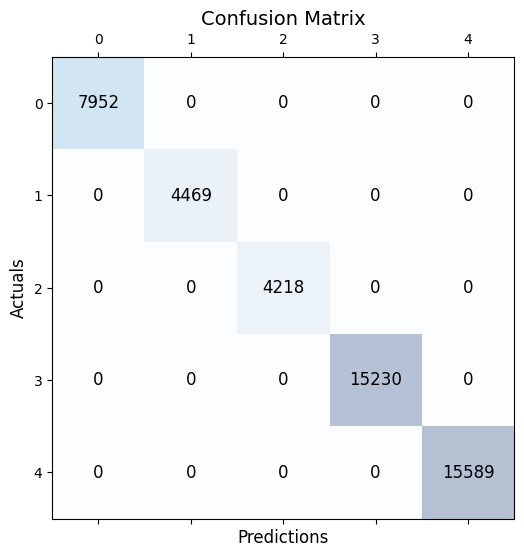

In [15]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/ED CNN")
plt.show()

# NB Model

In [16]:
# Model
nb_model = GaussianNB()

for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    nb_model, train_time = AttackClassificationModel.train_nb_knn(X_train, Y_train, nb_model)
    
    # Test
    Y_pred, test_time = AttackClassificationModel.test_nb_knn(X_test, nb_model)
    
    # Multi classification metrics
    labels = ['Bashlite_Combo','Bashlite_Junk','Bashlite_Scan','Bashlite_Udp', 'Bashlite_Tcp']
    acc, f1, pre, rec = AttackClassificationModel.get_scores(Y_test, Y_pred, labels)
    
    # Print results
    AttackClassificationModel.print_results(learning_rate,
                                            epochs,
                                            batch_size,
                                            X_train,
                                            X_val,
                                            X_test,
                                            opt_time,
                                            train_time,
                                            test_time,
                                            acc,
                                            f1,
                                            pre,
                                            rec,
                                            Y_test,
                                            Y_pred,
                                            "NB",
                                            "Results/ennio_doorbell.txt")
    
    print("")

Iteration 0
Testing time: 0.06336832046508789



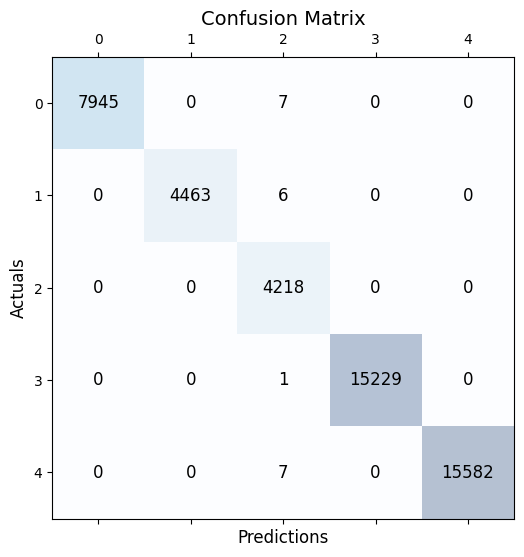

In [17]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/ED NB")
plt.show()

# KNN Model

In [18]:
# Model
knn_model = KNeighborsClassifier(n_neighbors = 50)

for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    knn_model, train_time = AttackClassificationModel.train_nb_knn(X_train, Y_train, knn_model)
    
    # Test
    Y_pred, test_time = AttackClassificationModel.test_nb_knn(X_test, knn_model)
    
    # Multi classification metrics
    labels = ['Bashlite_Combo','Bashlite_Junk','Bashlite_Scan','Bashlite_Udp', 'Bashlite_Tcp']
    acc, f1, pre, rec = AttackClassificationModel.get_scores(Y_test, Y_pred, labels)
    
    # Print results
    AttackClassificationModel.print_results(learning_rate,
                                            epochs,
                                            batch_size,
                                            X_train,
                                            X_val,
                                            X_test,
                                            opt_time,
                                            train_time,
                                            test_time,
                                            acc,
                                            f1,
                                            pre,
                                            rec,
                                            Y_test,
                                            Y_pred,
                                            "KNN",
                                            "Results/ennio_doorbell.txt")
    
    print("")

Iteration 0
Testing time: 35.69515538215637



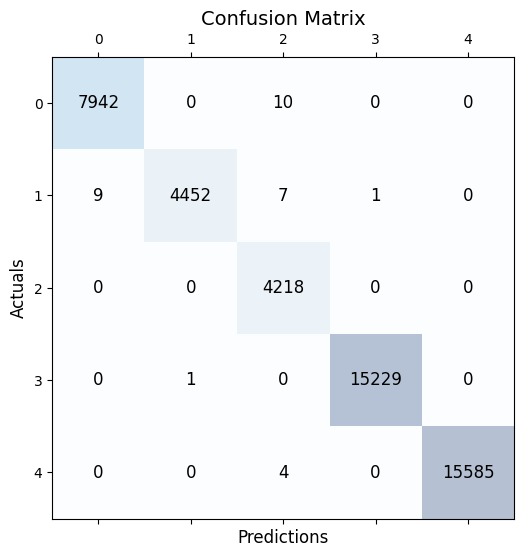

In [19]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/ED KNN")
plt.show()